In [91]:
# Install Pennylane
!pip install pennylane --upgrade;

In [92]:
# Install Fermionic Quantum Engine
!pip install git+https://github.com/quantumlib/OpenFermion-FQE --quiet;

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [93]:
# Import necessary packages
import copy
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

import openfermion as of
import fqe

In [94]:
import pennylane as qml
import tensorflow as tf
from pennylane import FermiC, FermiA
from pennylane import jordan_wigner

In [95]:
# Function to convert a 2^n statevector to an n state in bra-ket notation
def state_to_braket(state):
    braket = ""
    for i in range(len(state)):
        ## Only include states with non-zero amplitude
        if np.abs(state[i]) > 1e-10:
            ## Convert the index to binary and pad with zeros to get the basis state
            basis_state = format(i, 'b').zfill(int(np.log2(len(state))))
            ## Add the basis state and its amplitude to the braket string
            if len(braket) > 0:
                braket += " + "
            braket += f"({state[i]:.2f})|{basis_state}⟩"
    return braket

In [96]:
# Set quantum device with 16 qubits
dev = qml.device('default.qubit', wires=16)

In [97]:
# Set parameters
nsites = 8
l_up = 4
m_up = 4.5
sigma_up = 1

site_index = np.arange(1, nsites + 1)

# Construct hamiltonian matrix
spin_up_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)
spin_up_ham += np.diag(-l_up * np.exp(-0.5 * (site_index - m_up)**2) / sigma_up**2)
spin_down_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)

In [98]:
h0 = np.zeros((2 * nsites, 2 * nsites))
h0[::2, ::2] = spin_up_ham
h0[1::2, 1::2] = spin_down_ham

In [99]:
# Write the hamiltonian in FQE notation
fop = of.FermionOperator()
for p, q in product(range(2 * nsites), repeat=2):
    fop += of.FermionOperator(((p, 1), (q, 0)), coefficient=h0[p, q])

fop_mat = of.get_sparse_operator(fop)


For $N_{\uparrow} = N_{↓} = 2$

In [100]:
# Extract the sparse matrix
dim = 2**(2 * nsites)
diag_val = []
diag_pos = []

for ii in range(dim):
    ket = np.binary_repr(ii, width=2*nsites)
    ket_a = list(map(int, ket[::2]))
    ket_b = list(map(int, ket[1::2]))

    if np.isclose(sum(ket_a) + sum(ket_b), 4) and np.isclose(sum(ket_a) - sum(ket_b), 0):
        assert np.isclose(sum(ket_a), 2)
        assert np.isclose(sum(ket_b), 2)
        diag_val.append(1)
        diag_pos.append(ii)


proj_n = sparse.coo_matrix((diag_val, (diag_pos, diag_pos)), shape=(dim, dim))
fop_mat = proj_n @ fop_mat @ proj_n

In [101]:
# Diagonalize the hamiltonian to get the initial statevector
evals, evecs = sparse.linalg.eigsh(fop_mat.real, k=1)
# init_wfn_from_diag = fqe.from_cirq(evecs[:, 0].flatten(), thresh=1.0E-12)

In [102]:
statevector = evecs[:,0]

In [103]:
# Define K gate
def K(theta):
    return [
        [1, 0, 0, 0],
        [0, np.cos(theta), -1j * np.sin(theta), 0],
        [0, -1j * np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ]

In [104]:
# Perfom Jordan-Wigner Transformation on the number operator
def measure(i):
  coeffs = [0.5, -0.5]
  obs = [qml.Identity(i), qml.PauliZ(i)]
  return qml.Hamiltonian(coeffs, obs)

In [105]:
# Calculate the expectation value of the number operator on each of the qubit
measurements = []

@qml.qnode(dev, interface="tf")
def circuit(statevector, i):
  qml.QubitStateVector(statevector, wires=range(16))
  return qml.expval(measure(i))

for i in range(2 * nsites):
  measurements.append(circuit(statevector, i).numpy())

In [106]:
# Convert measurements from 16 qubits to 8 sites
measurements2 = []
measurements3 = []
ii = 0
while ii < 2 * nsites:
  measurements2.append(measurements[ii] + measurements[ii+1])
  measurements3.append(measurements[ii] - measurements[ii+1])
  ii += 2

charge_density = measurements2
spin_density = measurements3



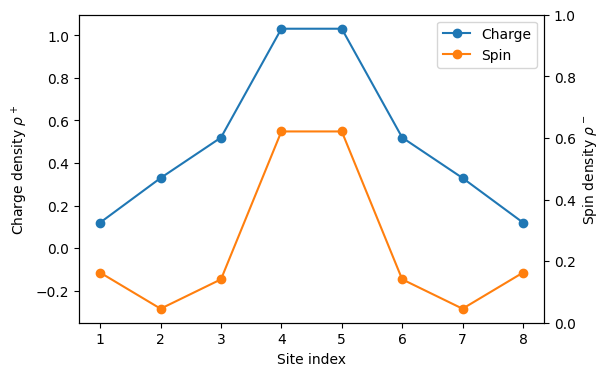

In [107]:
# Plot charge and spin density at each site of the initial state
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
plt.plot(site_index, charge_density, "-o", label="Charge")
plt.plot(site_index, spin_density, "-o", label="Spin")

ax.set_ylabel(r"Charge density $\rho^+$")
ax_twin = ax.twinx()
ax_twin.set_ylabel(r"Spin density $\rho^-$")

ax.set_xticks(site_index)
ax.set_xlabel("Site index")
ax.legend();

(<Figure size 1600x1700 with 1 Axes>, <Axes: >)


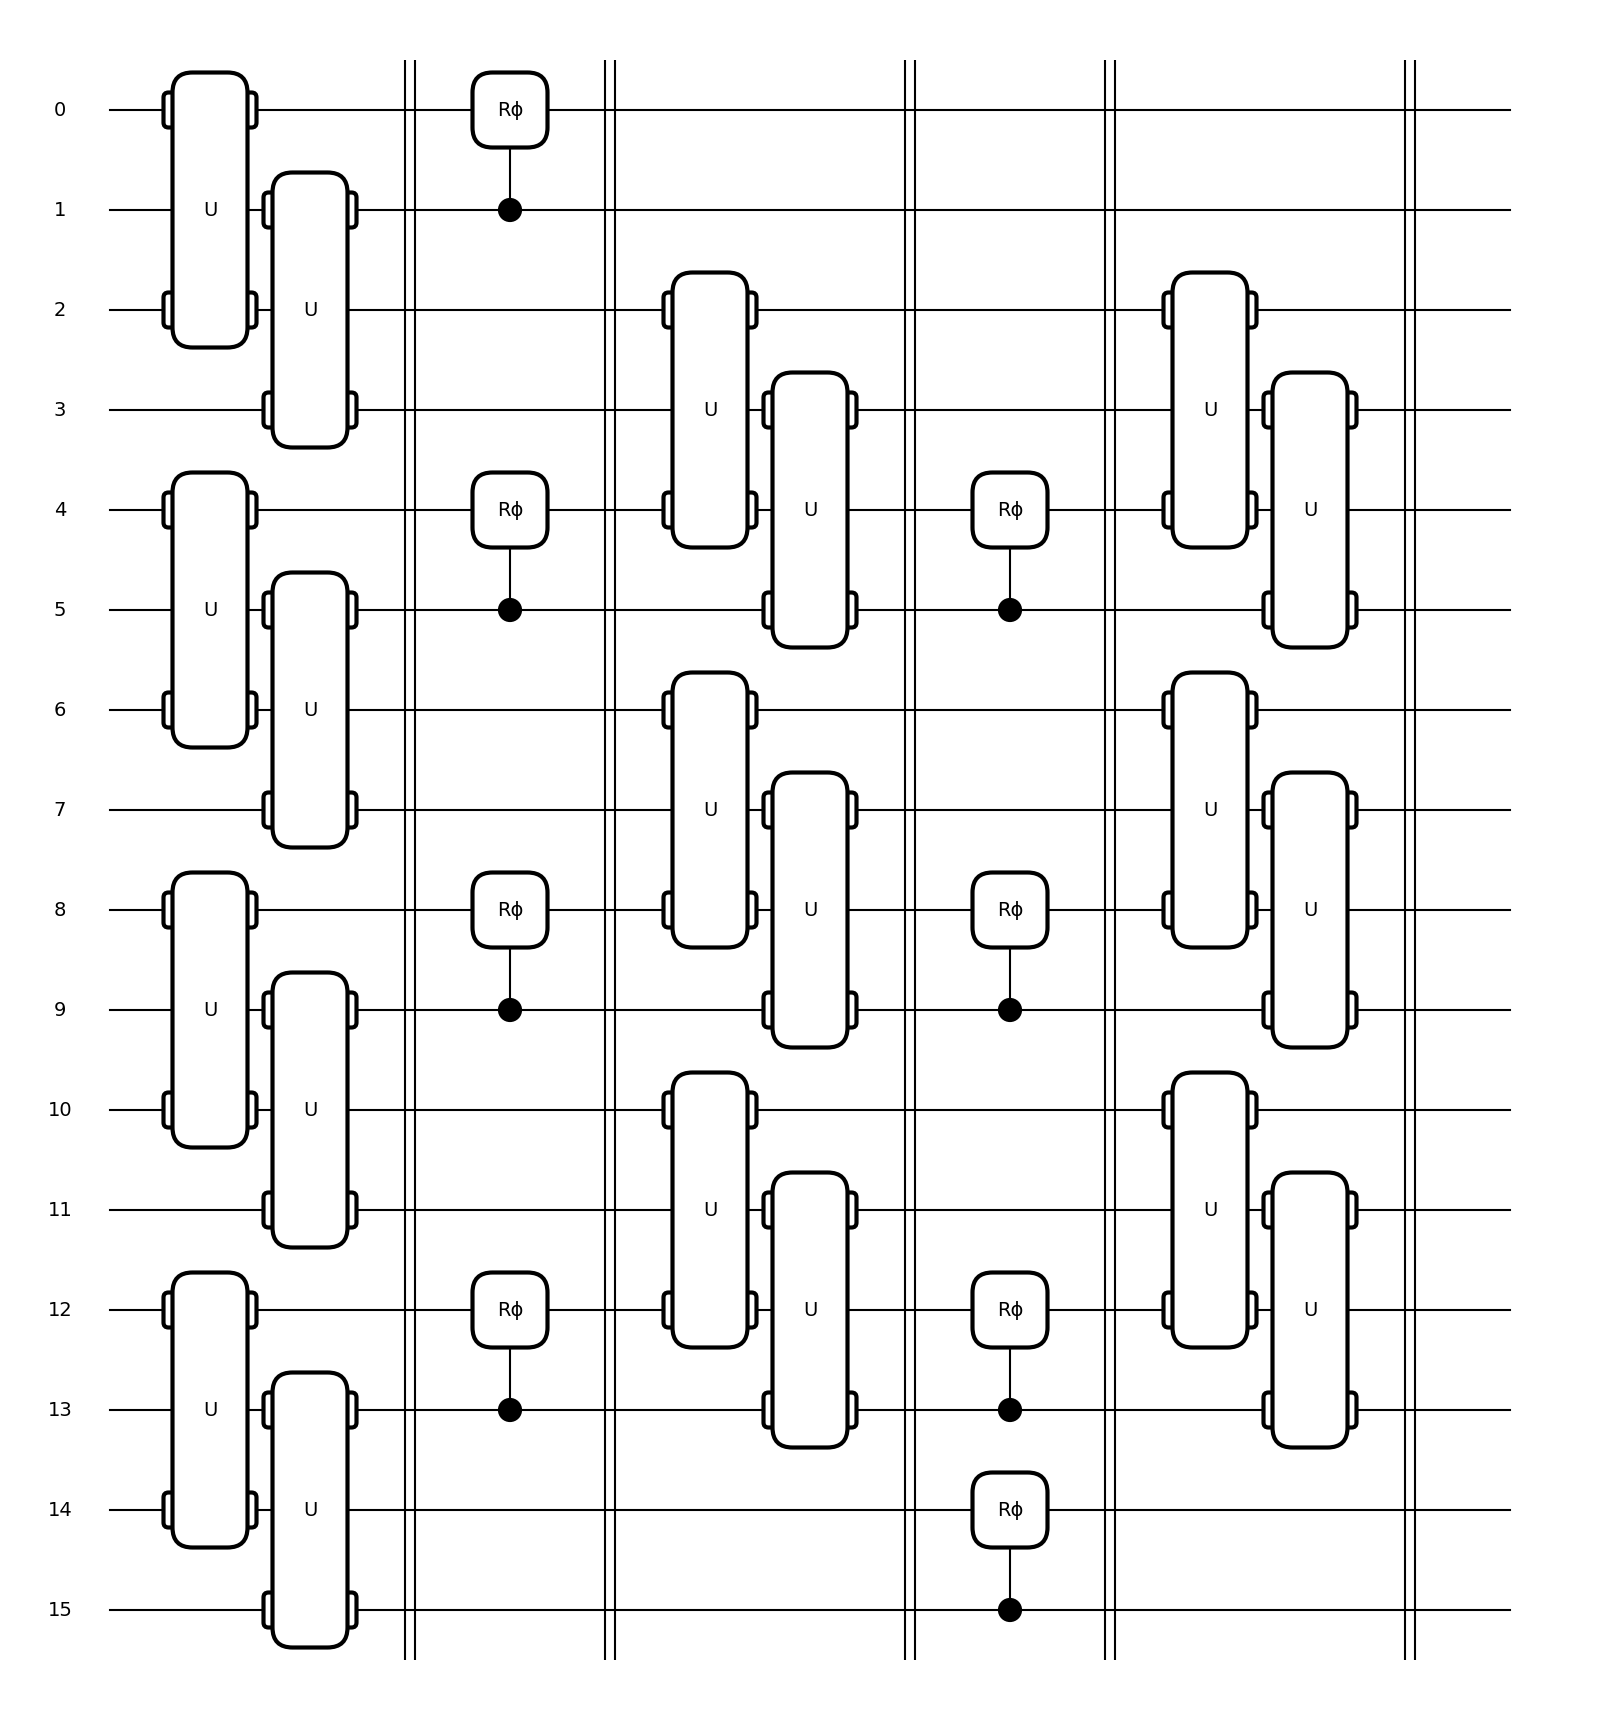

In [108]:
def trotter_step(params):
    # Define the repeated unitaries
    unitary_params = K(params[0])
    cphase_params = params[1]
    cphase_const = 2 * 0.138

    # Apply unitaries and barriers in a loop
    for qubits in [(2, 0), (3, 1), (6, 4), (7, 5), (10, 8), (11, 9), (14, 12), (15, 13)]:
        qml.QubitUnitary(unitary_params, wires=qubits)

    qml.Barrier(wires=range(16))

    # Apply CPhase gates in a loop
    for qubits in [(1, 0), (5, 4), (9, 8), (13, 12)]:
        qml.CPhase(cphase_params, wires=qubits)

    # for qubits in [(2, 0), (3, 1), (6, 4), (7, 5), (10, 8), (11, 9), (14, 12), (15, 13)]:
    #     qml.CPhase(cphase_const, wires=qubits)

    qml.Barrier(wires=range(16))

    # Apply the final unitaries
    for qubits in [(4, 2), (8, 6), (12, 10), (5, 3), (9, 7), (13, 11)]:
        qml.QubitUnitary(K(-np.pi/2), wires=qubits)

    qml.Barrier(wires=range(16))

    # Apply additional CPhase gates
    for qubits in [(5, 4), (9, 8), (13, 12), (15, 14)]:
        qml.CPhase(cphase_params, wires=qubits)

    # for qubits in [(4, 2), (8, 6), (12, 10), (5, 3), (9, 7), (13, 11)]:
    #     qml.CPhase(cphase_const, wires=qubits)

    qml.Barrier(wires=range(16))

    # Apply final unitaries with adjusted parameters
    for qubits in [(4, 2), (8, 6), (12, 10), (5, 3), (9, 7), (13, 11)]:
        qml.QubitUnitary(K(params[0] + np.pi/2), wires=qubits)

    qml.Barrier(wires=range(16))


print(qml.draw_mpl(trotter_step, show_all_wires=True, wire_order=range(16))([np.pi/4, np.pi/4]))

In [109]:
U = 0
J = 1
u = U / J

In [110]:
# Trotterization
dt = 0.3
trotter_steps = 10

initial_wfn = evecs[:,0]
final_wfn = initial_wfn


@qml.qnode(dev)
def full_circuit(initial_wfn, i):
    qml.QubitStateVector(initial_wfn, wires=range(2 * nsites))

    for tt in range(trotter_steps):
      trotter_step(params=[-dt, dt * U])

    return qml.expval(measure(i))

measurements_t = []

i = 0
while i < 2 * nsites:
    measurements_t.append(full_circuit(initial_wfn, i).numpy())
    i += 1

charge_density_2 = [measurements_t[j] + measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
spin_density_2 = [measurements_t[j] - measurements_t[j+1] for j in range(0, 2 * nsites, 2)]

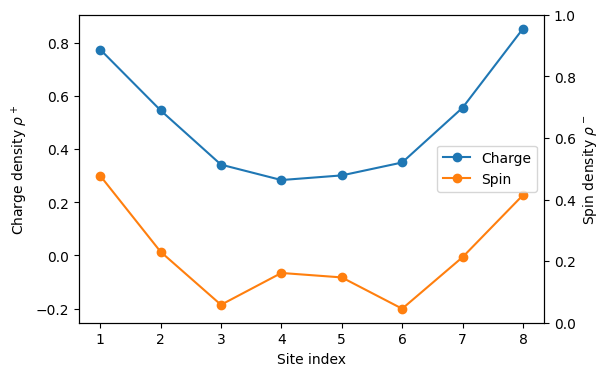

In [111]:
# plt.style.use('dark_background')



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
plt.plot(site_index, charge_density_2, "-o", label="Charge")
plt.plot(site_index, spin_density_2, "-o", label="Spin")

ax.set_ylabel(r"Charge density $\rho^+$")
ax_twin = ax.twinx()
ax_twin.set_ylabel(r"Spin density $\rho^-$")

ax.set_xticks(site_index)
ax.set_xlabel("Site index")
ax.legend()

# ax.set_ylim([0.0, 1])
# ax_twin.set_ylim([-0.5, 0.5]);

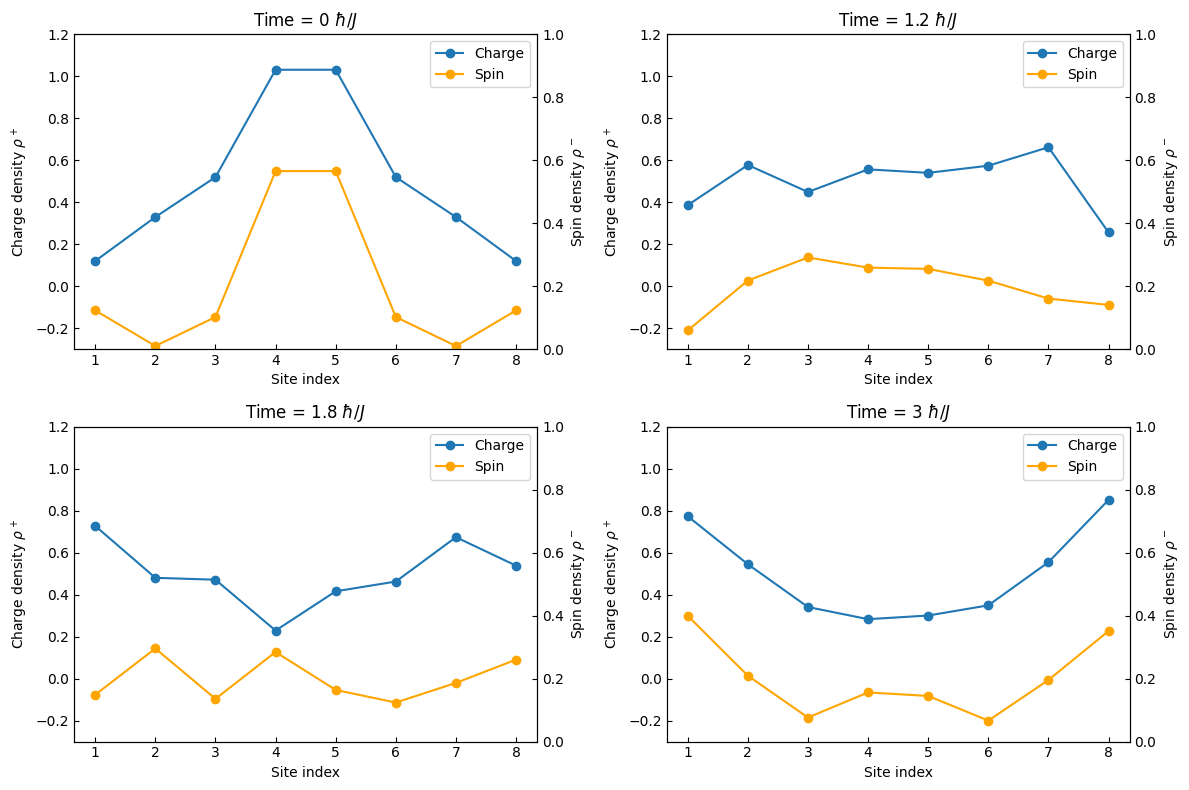

In [112]:
# Define the specific time points for the Trotter steps
time_points = [0, 1.2, 1.8, 3]

charge_densities = []
spin_densities = []

# Update trotter_steps_list to match the time_points
trotter_steps_list = [int(tp / dt) for tp in time_points]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for ax, trotter_steps, time_point in zip(axs.flatten(), trotter_steps_list, time_points):
    initial_wfn = evecs[:, 0]

    @qml.qnode(dev)
    def full_circuit(initial_wfn, i):
        qml.QubitStateVector(initial_wfn, wires=range(2 * nsites))

        for tt in range(trotter_steps):
            trotter_step(params=[-dt, dt * U])

        return qml.expval(measure(i))

    measurements_t = [full_circuit(initial_wfn, i).numpy() for i in range(2 * nsites)]

    charge_density_2 = [measurements_t[j] + measurements_t[j + 1] for j in range(0, 2 * nsites, 2)]
    charge_densities.append(charge_density_2)
    spin_density_2 = [measurements_t[j] - measurements_t[j + 1] for j in range(0, 2 * nsites, 2)]
    spin_densities.append(spin_density_2)

    ax.plot(site_index, charge_density_2, "-o", label="Charge")
    ax.plot(site_index, spin_density_2, "-o", label="Spin", color="orange")

    ax.set_ylabel(r"Charge density $\rho^+$")
    ax_twin = ax.twinx()
    ax_twin.set_ylabel(r"Spin density $\rho^-$")

    ax.set_xticks(site_index)
    ax.set_xlabel("Site index")
    ax.legend()
    ax.set_title(f"Time = {time_point} $\hbar / J$")


    ax.set_ylim([-0.3, 1.2])
    ax_twin.set_ylim([0, 1])
    ax.tick_params(which="both", direction="in")
    ax_twin.tick_params(which="both", direction="in")

plt.tight_layout()
plt.show()


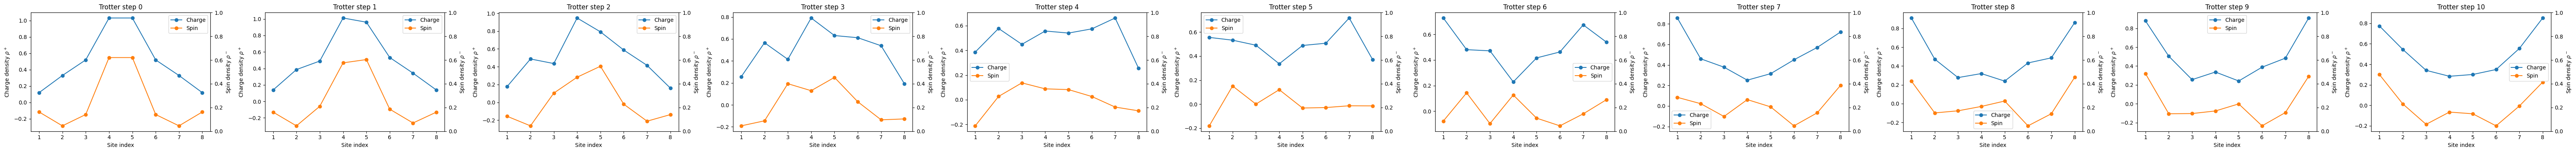

In [113]:
# Calculate and plot Charge and Spin densities
charge_densities = []
spin_densities = []

trotter_steps_list = range(11)
fig, axs = plt.subplots(nrows=1, ncols=len(trotter_steps_list), figsize=(6 * len(trotter_steps_list), 4))

for ax, trotter_steps in zip(axs, trotter_steps_list):
    initial_wfn = evecs[:,0]
    final_wfn = initial_wfn

    @qml.qnode(dev)
    def full_circuit(initial_wfn, i):
        qml.QubitStateVector(initial_wfn, wires=range(2 * nsites))

        for tt in range(trotter_steps):
          trotter_step(params=[-dt, dt * U])

        return qml.expval(measure(i))

    measurements_t = [full_circuit(initial_wfn, i).numpy() for i in range(2 * nsites)]

    charge_density_2 = [measurements_t[j] + measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
    charge_densities.append(charge_density_2)
    spin_density_2 = [measurements_t[j] - measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
    spin_densities.append(spin_density_2)

    ax.plot(site_index, charge_density_2, "-o", label="Charge")
    ax.plot(site_index, spin_density_2, "-o", label="Spin")

    ax.set_ylabel(r"Charge density $\rho^+$")
    ax_twin = ax.twinx()
    ax_twin.set_ylabel(r"Spin density $\rho^-$")

    ax.set_xticks(site_index)
    ax.set_xlabel("Site index")
    ax.legend()
    ax.set_title(f"Trotter step {trotter_steps}")

plt.tight_layout()
plt.show()

In [114]:
# Calculate and plot charge and spin spreads
charge_spread = []
spin_spread = []
spread_func = np.abs(np.arange(1, nsites + 1) - (nsites + 1) / 2)

for i in charge_densities:
  charge_spread.append(sum([i[j] * spread_func[j] for j in range(nsites)]))

for i in spin_densities:
  spin_spread.append(sum([i[j] * spread_func[j] for j in range(nsites)]))

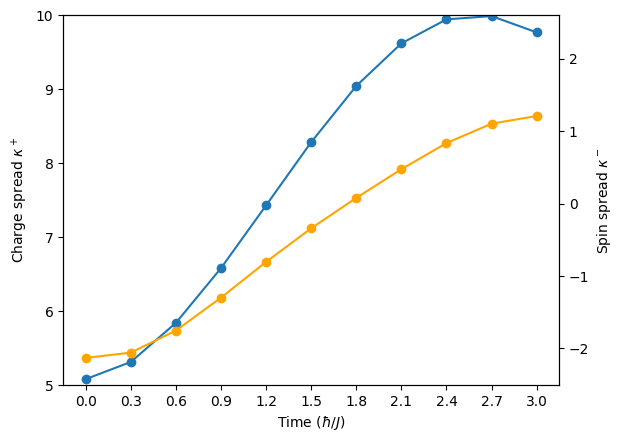

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=1)

real_times = np.arange(0, 3.3, 0.3)

stop = 11
ax.plot(real_times[:stop], charge_spread[:stop], "-o")
axtwin = ax.twinx()
axtwin.plot(real_times[:stop], spin_spread[:stop], "-o", color="orange")

ax.set_ylim([5, 10])
axtwin.set_ylim([-2.5, 2.6]);

ax.set_xticks(real_times[:stop])

ax.set_xlabel(r"Time $(\hbar / J)$")
ax.set_ylabel(r"Charge spread $\kappa^+$")
axtwin.set_ylabel(r"Spin spread $\kappa^-$");

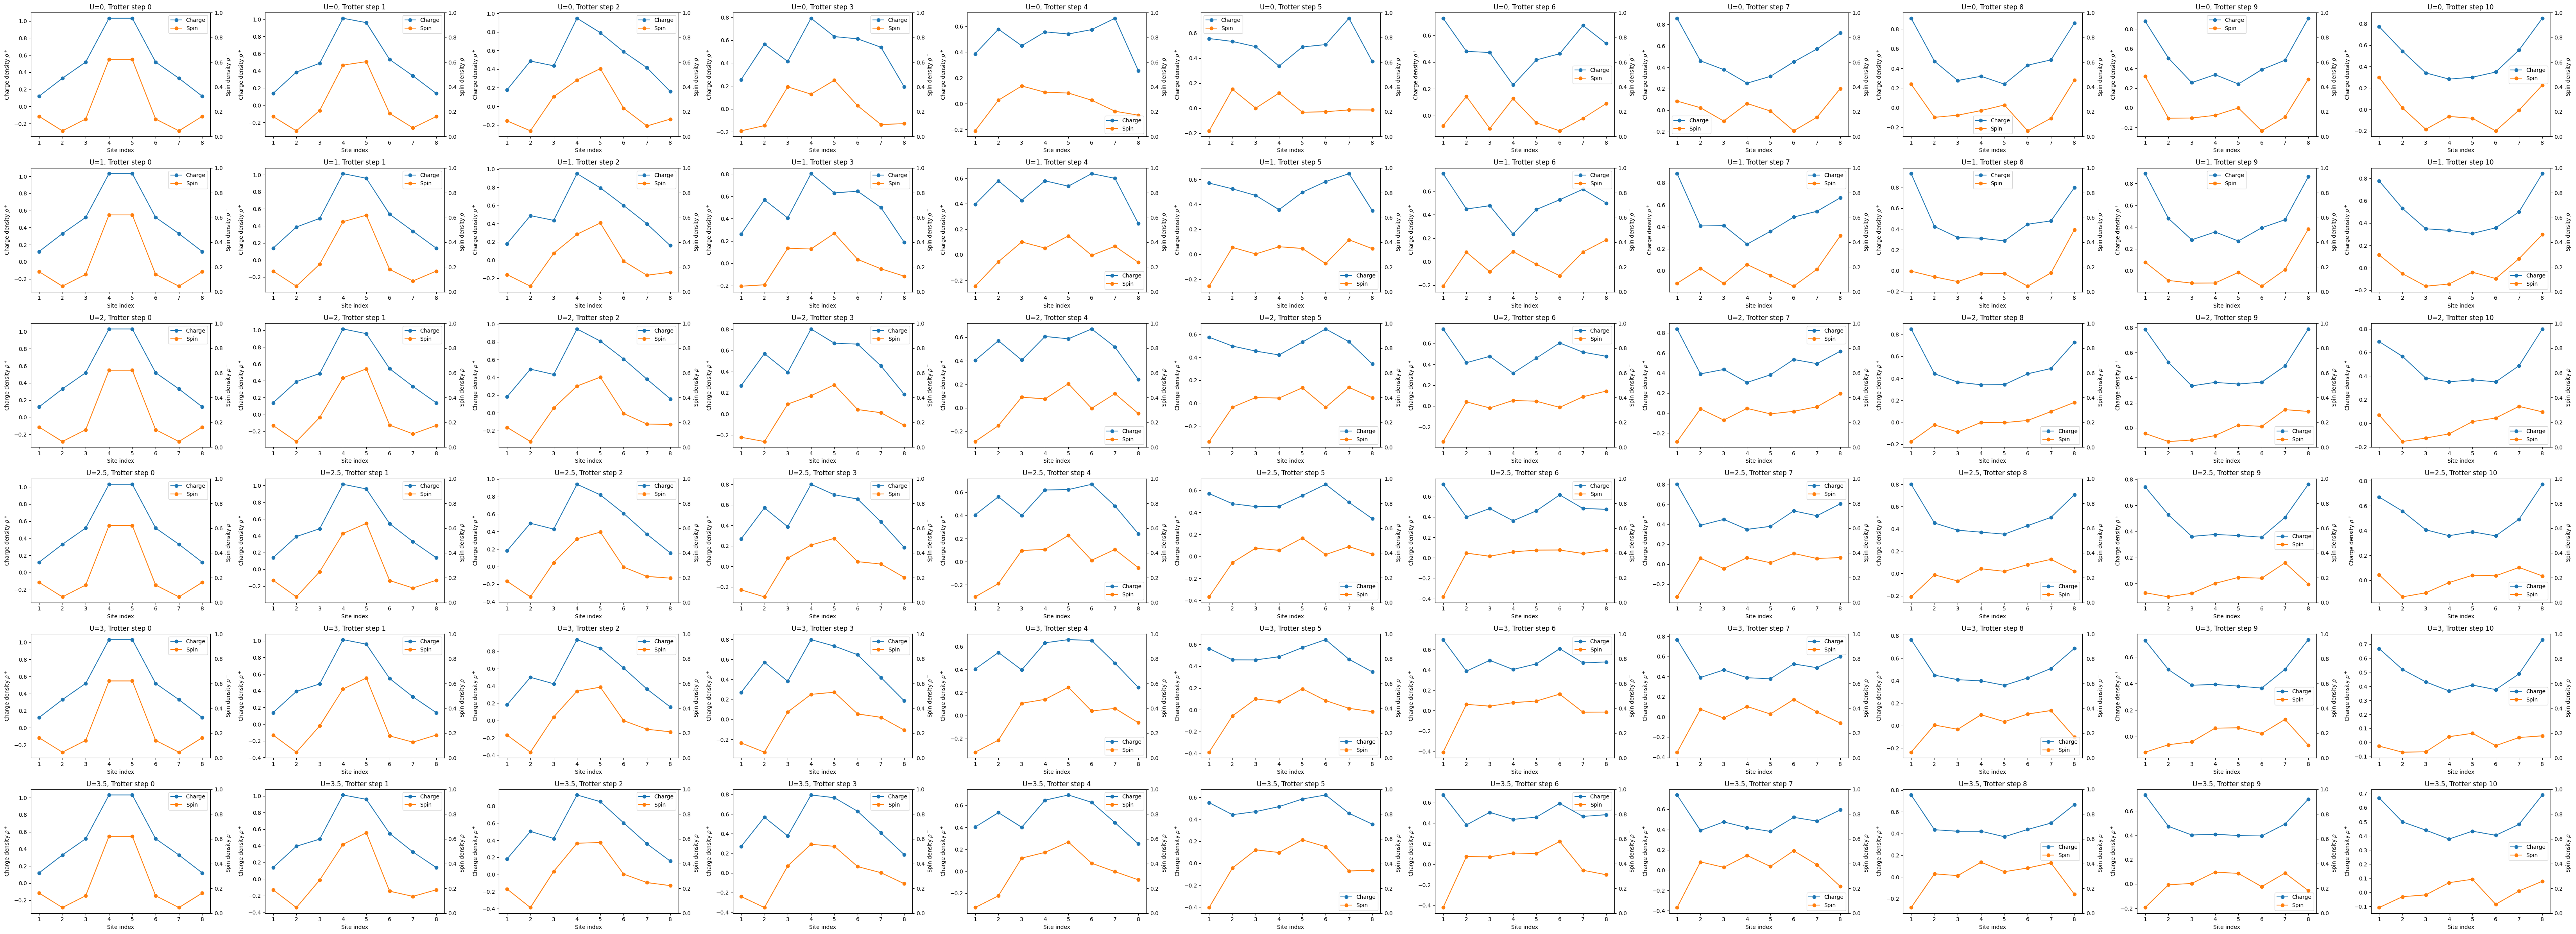

In [116]:
charge_densities = []
spin_densities = []

trotter_steps_list = range(11)
U_values = [0, 1, 2, 2.5, 3, 3.5]

fig, axs = plt.subplots(nrows=len(U_values), ncols=len(trotter_steps_list), figsize=(6 * len(trotter_steps_list), 4 * len(U_values)))

for row, U in enumerate(U_values):
    for col, trotter_steps in enumerate(trotter_steps_list):
        ax = axs[row][col]

        initial_wfn = evecs[:,0]
        final_wfn = initial_wfn

        @qml.qnode(dev)
        def full_circuit(initial_wfn, i):
            qml.QubitStateVector(initial_wfn, wires=range(2 * nsites))

            for tt in range(trotter_steps):
              trotter_step(params=[-dt, dt * U])

            return qml.expval(measure(i))

        measurements_t = [full_circuit(initial_wfn, i).numpy() for i in range(2 * nsites)]

        charge_density_2 = [measurements_t[j] + measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
        charge_densities.append(charge_density_2)
        spin_density_2 = [measurements_t[j] - measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
        spin_densities.append(spin_density_2)

        ax.plot(site_index, charge_density_2, "-o", label="Charge")
        ax.plot(site_index, spin_density_2, "-o", label="Spin")

        ax.set_ylabel(r"Charge density $\rho^+$")
        ax_twin = ax.twinx()
        ax_twin.set_ylabel(r"Spin density $\rho^-$")

        ax.set_xticks(site_index)
        ax.set_xlabel("Site index")
        ax.legend()
        ax.set_title(f"U={U}, Trotter step {trotter_steps}")

plt.tight_layout()
plt.show()

In [117]:
charge_spread = [sum([i[j] * spread_func[j] for j in range(nsites)]) for i in charge_densities]
spin_spread = [sum([i[j] * spread_func[j] for j in range(nsites)]) for i in spin_densities]

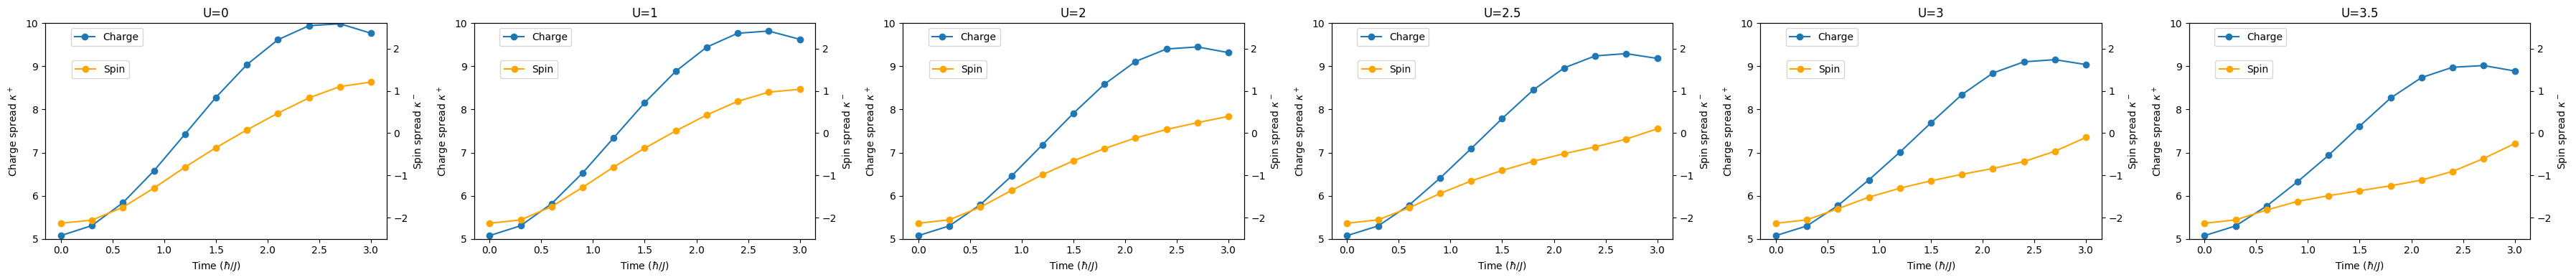

In [118]:
fig, axs = plt.subplots(nrows=1, ncols=len(U_values), figsize=(6 * len(U_values), 4))

for col, U in enumerate(U_values):
    ax = axs[col]

    start = col * 11
    stop = start + 11

    ax.plot(real_times, charge_spread[start:stop], "-o", label="Charge")
    ax.set_ylim([5, 10])
    ax.set_xlabel(r"Time $(\hbar / J)$")
    ax.set_ylabel(r"Charge spread $\kappa^+$")

    axtwin = ax.twinx()
    axtwin.plot(real_times, spin_spread[start:stop], "-o", label="Spin", color="orange")
    axtwin.set_ylim([-2.5, 2.6])
    axtwin.set_ylabel(r"Spin spread $\kappa^-$")

    ax.legend(loc="upper right", bbox_to_anchor=(0.3, 1))
    axtwin.legend(loc="upper right", bbox_to_anchor=(0.26, 0.85))

    ax.set_title(f"U={U}")

plt.tight_layout()
plt.show()

In [119]:
# Define a function to calculate the numerical derivative
def numerical_derivative(data, dt):
    derivative = [(data[i+1] - data[i]) / dt for i in range(len(data) - 1)]
    last_derivative = (data[-1] - data[-2]) / dt
    derivative.append(last_derivative)
    return derivative

charge_spread_derivative = numerical_derivative(charge_spread, dt)
spin_spread_derivative = numerical_derivative(spin_spread, dt)


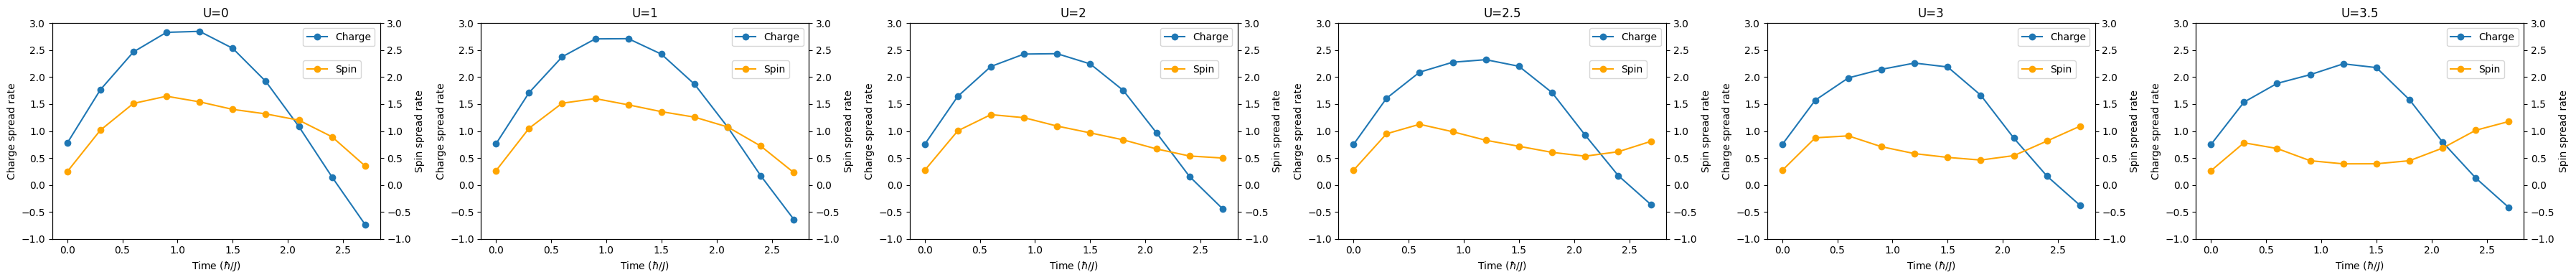

In [120]:
# Plot Spread rates
fig, axs = plt.subplots(nrows=1, ncols=len(U_values), figsize=(6 * len(U_values), 4))

for col, U in enumerate(U_values):
    ax = axs[col]

    start = col * 11
    stop = start + 10

    ax.plot(real_times[:-1], charge_spread_derivative[start:stop], "-o", label="Charge")
    ax.set_ylim([-1, 3])
    ax.set_xlabel(r"Time $(\hbar / J)$")
    ax.set_ylabel(r"Charge spread rate")


    axtwin = ax.twinx()
    axtwin.plot(real_times[:-1], spin_spread_derivative[start:stop], "-o", label="Spin", color="orange")
    axtwin.set_ylim([-1, 3])
    axtwin.set_ylabel(r"Spin spread rate")

    ax.legend(loc="upper left", bbox_to_anchor=(0.75, 1))
    axtwin.legend(loc="upper left", bbox_to_anchor=(0.75, 0.85))

    ax.set_title(f"U={U}")

plt.tight_layout()
plt.show()

---

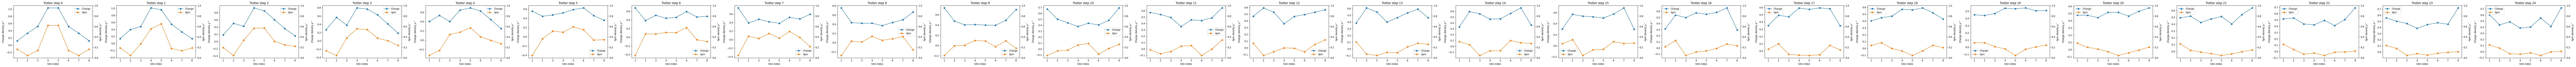

In [121]:
# Calculate and plot Charge and Spin densities
charge_densities = []
spin_densities = []

trotter_steps_list = range(25)
fig, axs = plt.subplots(nrows=1, ncols=len(trotter_steps_list), figsize=(6 * len(trotter_steps_list), 4))

for ax, trotter_steps in zip(axs, trotter_steps_list):
    initial_wfn = evecs[:,0]
    final_wfn = initial_wfn

    @qml.qnode(dev)
    def full_circuit(initial_wfn, i):
        qml.QubitStateVector(initial_wfn, wires=range(2 * nsites))

        for tt in range(trotter_steps):
          trotter_step(params=[-dt, dt * U])

        return qml.expval(measure(i))

    measurements_t = [full_circuit(initial_wfn, i).numpy() for i in range(2 * nsites)]

    charge_density_2 = [measurements_t[j] + measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
    charge_densities.append(charge_density_2)
    spin_density_2 = [measurements_t[j] - measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
    spin_densities.append(spin_density_2)

    ax.plot(site_index, charge_density_2, "-o", label="Charge")
    ax.plot(site_index, spin_density_2, "-o", label="Spin")

    ax.set_ylabel(r"Charge density $\rho^+$")
    ax_twin = ax.twinx()
    ax_twin.set_ylabel(r"Spin density $\rho^-$")

    ax.set_xticks(site_index)
    ax.set_xlabel("Site index")
    ax.legend()
    ax.set_title(f"Trotter step {trotter_steps}")

plt.tight_layout()
plt.show()

In [123]:
# Calculate and plot charge and spin spreads
charge_spread = []
spin_spread = []
spread_func = np.abs(np.arange(1, nsites + 1) - (nsites + 1) / 2)

for i in charge_densities:
  charge_spread.append(sum([i[j] * spread_func[j] for j in range(nsites)]))

for i in spin_densities:
  spin_spread.append(sum([i[j] * spread_func[j] for j in range(nsites)]))

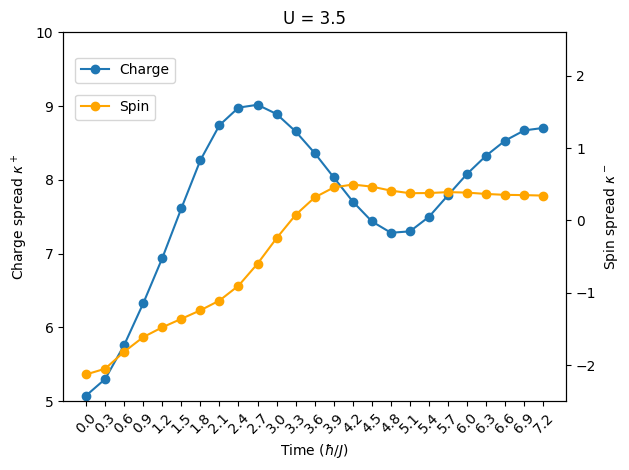

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=1)

real_times = np.arange(0, len(trotter_steps_list)*0.3, 0.3)

stop = len(trotter_steps_list)
ax.plot(real_times[:stop], charge_spread[:stop], "-o", label="Charge")
axtwin = ax.twinx()
axtwin.plot(real_times[:stop], spin_spread[:stop], "-o", label="Spin", color="orange")

ax.legend(loc="upper left", bbox_to_anchor=(0.01, 0.95), ncol=1)
axtwin.legend(loc="upper left", bbox_to_anchor=(0.01, 0.85), ncol=1)

ax.set_ylim([5, 10])
axtwin.set_ylim([-2.5, 2.6])

ax.set_xticks(real_times[:stop])

ax.set_xlabel(r"Time $(\hbar / J)$")
ax.set_ylabel(r"Charge spread $\kappa^+$")
axtwin.set_ylabel(r"Spin spread $\kappa^-$")

ax.tick_params(axis='x', rotation=45)
plt.title(f"U = {U}")

fig.tight_layout()

plt.show()


Damped Oscillation

---

Let's say there are 8 electrons instead of 4

In [125]:
# Large U (Mott?)
U = 16.5
J = 1
u = U / J

In [126]:
# Set parameters
nsites = 8
l_up = 0 #8
m_up = 4.5
sigma_up = 1

site_index = np.arange(1, nsites + 1)

# Construct hamiltonian matrix
spin_up_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)
spin_up_ham += np.diag(-l_up * np.exp(-0.5 * (site_index - m_up)**2) / sigma_up**2)
spin_down_ham = np.diag([-1.] * (nsites - 1), k=1) + np.diag([-1.] * (nsites - 1), k=-1)

In [127]:
h0 = np.zeros((2 * nsites, 2 * nsites))
h0[::2, ::2] = spin_up_ham
h0[1::2, 1::2] = spin_down_ham

In [128]:
# Write the hamiltonian in FQE notation
fop = of.FermionOperator()
for p, q in product(range(2 * nsites), repeat=2):
    fop += of.FermionOperator(((p, 1), (q, 0)), coefficient=h0[p, q])

fop_mat = of.get_sparse_operator(fop)


In [129]:
dim = 2**(2 * nsites)
diag_val = []
diag_pos = []

for ii in range(dim):
    ket = np.binary_repr(ii, width=2*nsites)
    ket_a = list(map(int, ket[::2]))
    ket_b = list(map(int, ket[1::2]))

    if np.isclose(sum(ket_a) + sum(ket_b), 8) and np.isclose(sum(ket_a) - sum(ket_b), 0): # Total 8 electrons
        assert np.isclose(sum(ket_a), 4)  # Four electrons in ket_a
        assert np.isclose(sum(ket_b), 4)  # Four electrons in ket_b
        diag_val.append(1)
        diag_pos.append(ii)

proj_n = sparse.coo_matrix((diag_val, (diag_pos, diag_pos)), shape=(dim, dim))
fop_mat = proj_n @ fop_mat @ proj_n


In [130]:
# Diagonalize the hamiltonian to get the initial statevector
evals, evecs = sparse.linalg.eigsh(fop_mat.real, k=1)
# init_wfn_from_diag = fqe.from_cirq(evecs[:, 0].flatten(), thresh=1.0E-12)

In [131]:
statevector = evecs[:,0]

In [132]:
# Calculate the expectation value of the number operator on each of the qubit
measurements = []

@qml.qnode(dev, interface="tf")
def circuit(statevector, i):
  qml.QubitStateVector(statevector, wires=range(16))
  return qml.expval(measure(i))

for i in range(2 * nsites):
  measurements.append(circuit(statevector, i).numpy())

In [133]:
# Convert measurements from 16 qubits to 8 sites
measurements2 = []
measurements3 = []
ii = 0
while ii < 2 * nsites:
  measurements2.append(measurements[ii] + measurements[ii+1])
  measurements3.append(measurements[ii] - measurements[ii+1])
  ii += 2

charge_density = measurements2
spin_density = measurements3



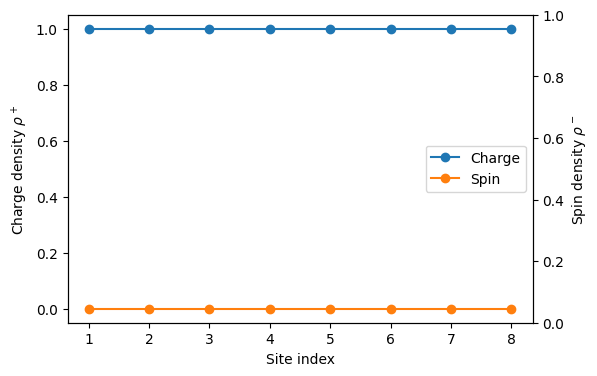

In [134]:
# Plot charge and spin density at each site of the initial state
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
plt.plot(site_index, charge_density, "-o", label="Charge")
plt.plot(site_index, spin_density, "-o", label="Spin")

ax.set_ylabel(r"Charge density $\rho^+$")
ax_twin = ax.twinx()
ax_twin.set_ylabel(r"Spin density $\rho^-$")

ax.set_xticks(site_index)
ax.set_xlabel("Site index")
ax.legend();

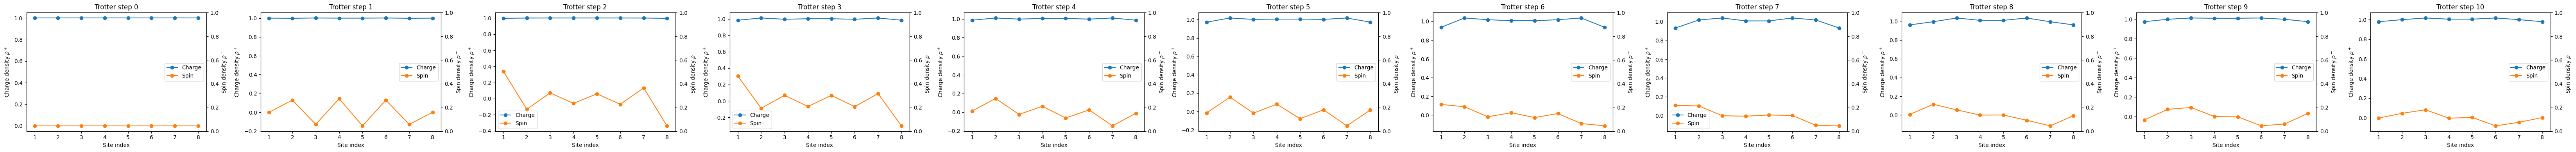

In [135]:
# Calculate and plot Charge and Spin densities
charge_densities = []
spin_densities = []

trotter_steps_list = range(11)
fig, axs = plt.subplots(nrows=1, ncols=len(trotter_steps_list), figsize=(6 * len(trotter_steps_list), 4))

for ax, trotter_steps in zip(axs, trotter_steps_list):
    initial_wfn = evecs[:,0]
    final_wfn = initial_wfn

    @qml.qnode(dev)
    def full_circuit(initial_wfn, i):
        qml.QubitStateVector(initial_wfn, wires=range(2 * nsites))

        for tt in range(trotter_steps):
          trotter_step(params=[-dt, dt * U])

        return qml.expval(measure(i))

    measurements_t = [full_circuit(initial_wfn, i).numpy() for i in range(2 * nsites)]

    charge_density_2 = [measurements_t[j] + measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
    charge_densities.append(charge_density_2)
    spin_density_2 = [measurements_t[j] - measurements_t[j+1] for j in range(0, 2 * nsites, 2)]
    spin_densities.append(spin_density_2)

    ax.plot(site_index, charge_density_2, "-o", label="Charge")
    ax.plot(site_index, spin_density_2, "-o", label="Spin")

    ax.set_ylabel(r"Charge density $\rho^+$")
    ax_twin = ax.twinx()
    ax_twin.set_ylabel(r"Spin density $\rho^-$")

    ax.set_xticks(site_index)
    ax.set_xlabel("Site index")
    ax.legend()
    ax.set_title(f"Trotter step {trotter_steps}")

plt.tight_layout()
plt.show()

Mott regime?

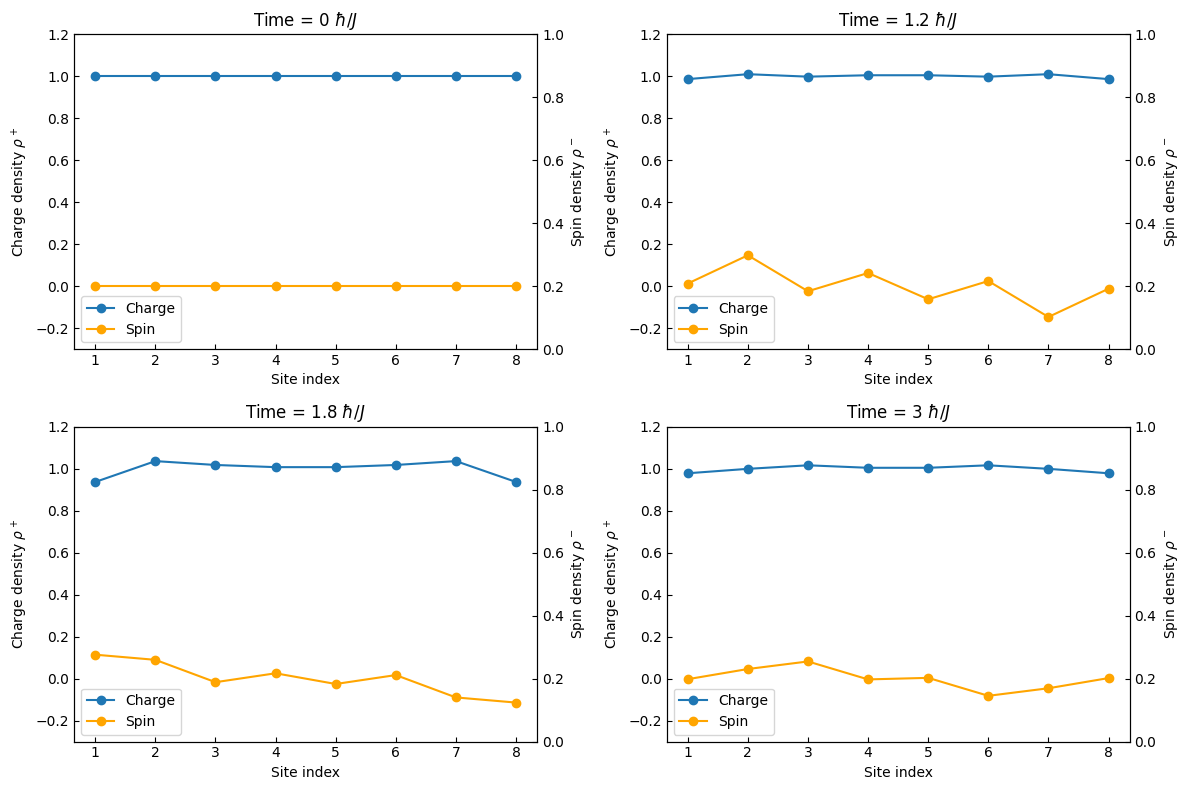

In [136]:
# Define the specific time points for the Trotter steps
time_points = [0, 1.2, 1.8, 3]

charge_densities = []
spin_densities = []

# Update trotter_steps_list to match the time_points
trotter_steps_list = [int(tp / dt) for tp in time_points]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for ax, trotter_steps, time_point in zip(axs.flatten(), trotter_steps_list, time_points):
    initial_wfn = evecs[:, 0]

    @qml.qnode(dev)
    def full_circuit(initial_wfn, i):
        qml.QubitStateVector(initial_wfn, wires=range(2 * nsites))

        for tt in range(trotter_steps):
            trotter_step(params=[-dt, dt * U])

        return qml.expval(measure(i))

    measurements_t = [full_circuit(initial_wfn, i).numpy() for i in range(2 * nsites)]

    charge_density_2 = [measurements_t[j] + measurements_t[j + 1] for j in range(0, 2 * nsites, 2)]
    charge_densities.append(charge_density_2)
    spin_density_2 = [measurements_t[j] - measurements_t[j + 1] for j in range(0, 2 * nsites, 2)]
    spin_densities.append(spin_density_2)

    ax.plot(site_index, charge_density_2, "-o", label="Charge")
    ax.plot(site_index, spin_density_2, "-o", label="Spin", color="orange")

    ax.set_ylabel(r"Charge density $\rho^+$")
    ax_twin = ax.twinx()
    ax_twin.set_ylabel(r"Spin density $\rho^-$")

    ax.set_xticks(site_index)
    ax.set_xlabel("Site index")
    ax.legend()
    ax.set_title(f"Time = {time_point} $\hbar / J$")


    ax.set_ylim([-0.3, 1.2])
    ax_twin.set_ylim([0, 1])
    ax.tick_params(which="both", direction="in")
    ax_twin.tick_params(which="both", direction="in")

plt.tight_layout()
plt.show()
